In [ ]:
#%pip install --upgrade pandas-datareader

In [ ]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from scipy import linalg

import pandas as pd
import pandas_datareader.data as web

In [5]:
d=2
M=150

# Matrix with ones on the lower side diagonal (starting from position 2)
def nilpotent(M):
    B = np.zeros((M,M))
    for i in range(2,M):
        B[i,i-1]=1.0
    return B

# Vectors e_i
def canonical(i,M):
    e = np.zeros((M,1))
    e[i,0]=1.0
    return e

Note to myself, in the following state represents the stochastic process $X_t$ and increment represents the increment $du^{i}(t)$. The following vector field functions represent different possibilities for $V_i$.

In [6]:
def vectorfieldSABR(state,increment):
    return np.array([(np.sqrt(state[0]**2))**0.7*np.exp(-0.5*state[1]),0.1])*increment[0]+np.array([0,0.25*(state[0]+state[1])])*increment[1]

In [7]:
def randomAbeta(d,M):
    A = []
    beta = []
    for i in range(d):
        B = 0.0*nilpotent(M) + np.random.normal(0.0,0.03,size=(M,M))
        B = np.random.permutation(B)
        A = A + [B]
        beta = beta + [0.0*canonical(i,M)+np.random.normal(0.0,0.03,size=(M,1))]
    return [A,beta]

In [8]:
Abeta = randomAbeta(d,M)
A = Abeta[0]
beta = Abeta[1]

def sigmoid(x):
    return np.tanh(x)

# Reservoirfield approximates a vector field 
def reservoirfield(state,increment):
    value = np.zeros((M,1))
    for i in range(d):
        value = value + sigmoid(np.matmul(A[i],state) + beta[i])*increment[i]
    return value

In [9]:
class SDE:
    def __init__(self,timehorizon,initialvalue,dimension,dimensionBM,dimensionR,vectorfield,timesteps):
        self.timehorizon = timehorizon
        self.initialvalue = initialvalue # np array
        self.dimension = dimension
        self.dimensionBM = dimensionBM
        self.dimensionR = dimensionR
        self.vectorfield = vectorfield
        self.timesteps = timesteps

    def path(self):
        BMpath = [np.zeros(self.dimensionBM)] # We store it in a list to have the whole BM path
        SDEpath = [np.array([1.0, self.initialvalue])]
        for i in range(self.timesteps):
            helper = np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))] # represents the path of X_t using the SDE (and hence the vf)
        return [BMpath, SDEpath]

    def anypath(self):
        BMpath = [np.zeros(self.dimensionBM)]
        SDEpath = [np.array([1.0, self.initialvalue])]#[np.ones((self.dimension,1))*self.initialvalue]

        for i in range(self.timesteps):
            helper = np.cos(BMpath[-1]*50)*self.timehorizon/self.timesteps#np.random.normal(0,np.sqrt(self.timehorizon/self.timesteps),self.dimensionBM)
            BMpath = BMpath + [BMpath[-1]+helper]
            SDEpath = SDEpath + [np.exp(-0.0*self.timehorizon/self.timesteps)*(SDEpath[-1]+self.vectorfield(SDEpath[-1],helper))]

        return [BMpath, SDEpath]

    def reservoir(self,BMpath,scaling,k):
        reservoirpath = [canonical(k,self.dimensionR)*self.initialvalue] # e_k*X_0
        for i in range(self.timesteps):
            increment = scaling*(BMpath[i+1]-BMpath[i])
            reservoirpath = reservoirpath + [np.exp(-1.0*self.timehorizon/self.timesteps)*(reservoirpath[-1]+reservoirfield(reservoirpath[-1],increment))]
        return reservoirpath

In [10]:
Sabr = SDE(1,1.0,2,d,M,vectorfieldSABR,10000) # u is 2 dimensional and the BM also.
training = Sabr.path() # path contains the path of a BM and the path of the SDE (We have two graphs in the output)

In [11]:
print(training[0][:6000])

[array([0., 0.]), array([-0.01001298, -0.00699551]), array([-0.00287064, -0.00124698]), array([ 0.00252621, -0.01298658]), array([-0.006234  , -0.00935665]), array([-0.00365367,  0.00303914]), array([-0.02113124,  0.02982631]), array([-0.04349285,  0.03016881]), array([-0.04034903,  0.02528558]), array([-0.0563002 ,  0.00962115]), array([-0.07062227,  0.00937926]), array([-0.06278983,  0.01445717]), array([-0.0689193 , -0.01117324]), array([-0.07111459, -0.02176659]), array([-0.06194604, -0.02301896]), array([-0.05696494, -0.01193038]), array([-0.05431242, -0.02781833]), array([-0.04700282, -0.0173136 ]), array([-0.05809615, -0.03103414]), array([-0.05440668, -0.04704158]), array([-0.05690304, -0.05162052]), array([-0.05660058, -0.05824226]), array([-0.07067962, -0.05532251]), array([-0.05656844, -0.05858336]), array([-0.04640464, -0.05766974]), array([-0.04264507, -0.06670066]), array([-0.03565141, -0.06701097]), array([-0.02319912, -0.08902507]), array([-0.01167096, -0.09243726]), ar

The first plot represents the two coordinates of a BM and the second plot represents the two coordinate of the SDE path

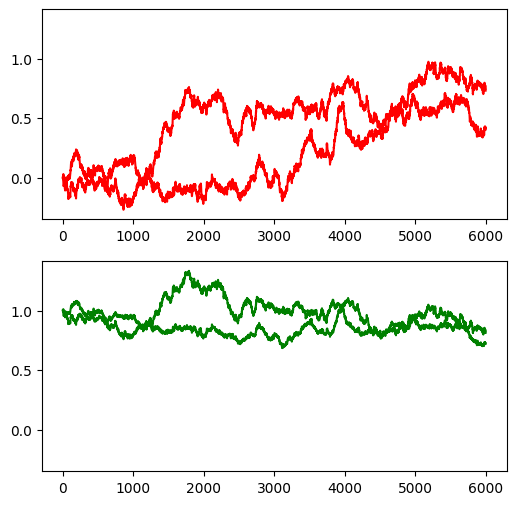

In [12]:
f1,p1=plt.subplots(2,1,figsize=(6,6),sharey=True)
p1[0].plot(training[0][:6000],'r')
p1[1].plot(training[1][:6000],'g')
#plt.savefig('trainingpath.pdf')
plt.show()

In [ ]:
BMpath=training[0]
Y = training[1] # this represents the SDE path
#Ydata = np.squeeze(Y)
#Ydatadiff = np.diff(Ydata,axis=0)
#Ytrain = np.concatenate((Ydata[:2000],Ydatadiff[:2000:1]),axis=0)
#np.shape(Ytrain)

In [ ]:
Ydata = np.squeeze(Y)
Ytrain = Ydata[:6000]

np.shape(Ytrain)

In [ ]:
"""
x = np.array([[1, 3, 6, 10], [0, 5, 6, 8], [10, 9, 1, 5]])
>>> np.diff(x, axis=0)
array([[-1  2  0 -2],
       [10  4 -5 -3]])
"""

In [ ]:
X=Sabr.reservoir(BMpath,1,0) # This is the model we use to approximate the real solution
#np.shape(X)
Xdata = np.squeeze(X) 
#for l in range(1):
#    Xscaled=Sabr.reservoir(BMpath,0.5-l*0.1,0)
#    Xscaleddata=np.squeeze(Xscaled)
#    Xdata=np.concatenate((Xdata,Xscaleddata),axis=1)
#Xdata = np.concatenate((Xdata,Xdata**2),axis=1)
#Xdata = np.concatenate((Xdata,np.arctan(Xdata)),axis=1)#,np.arctan(4*Xdata)),axis=1)
#Xdatadiff = np.diff(Xdata,axis=0)
#Xtrain=np.concatenate((Xdata[:2000],Xdatadiff[:2000:1]),axis=0)
Xtrain = Xdata[:6000]
np.shape(Xtrain)

In [ ]:
from sklearn import linear_model
import pandas as pd
lm = linear_model.Ridge(alpha=0.05)#
model = lm.fit(Xtrain,Ytrain)
plt.plot(model.predict(Xtrain),'r')
plt.plot(Ytrain,'b')
plt.show()
model.score(Xtrain,Ytrain)
model.coef_

In [ ]:
f,p=plt.subplots(2,1,figsize=(6,6),sharey=True)

N=2

for i in range(N):
    p[i].plot(model.predict(Xdata[6000:])[:,i],'b')
    p[i].plot(Ydata[6000:][:,i],'g')
#plt.savefig('training.pdf')
plt.show()